In [152]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import random 
import math
import numpy as np

In [153]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [154]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)

In [155]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1

X, Y = torch.tensor(X), torch.tensor(Y)

In [156]:
# data set splits 80%, 10%, 10%
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [157]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaimin init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

In [158]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.runnig_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            x_mean = x.mean(dim=0, keepdim=True) # batch mean
            x_var = x.var(dim=0, keepdim=True) # batch variance 
        else:
            x_mean = self.running_mean
            x_var = self.runnig_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # normalize 
        self.out = self.gamma * x_hat + self.beta 
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
                self.runnig_var = (1-self.momentum) * self.runnig_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10 # dim of the character embedding vector
n_hidden = 100 # the # of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(          n_hidden, n_hidden), Tanh(),
#     Linear(          n_hidden, n_hidden), Tanh(),
#     Linear(          n_hidden, n_hidden), Tanh(),
#     Linear(          n_hidden, n_hidden), Tanh(),
#     Linear(          n_hidden, vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confindent
    # layers[-1].weights *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]  
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

47024


In [159]:
# train
inxs = []
losses = []
batch_size = 64
steps = 1_000_000
for i in range(steps):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[training_set[inx]] # grab only those rows from the minibatch 
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_training_set[inx]) 
    
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = 0.1 if i < 250_000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    # if i % 1000 == 0: # print every once in a while
    #     print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(i)

loss.item() # best loss 2.14

KeyboardInterrupt: 

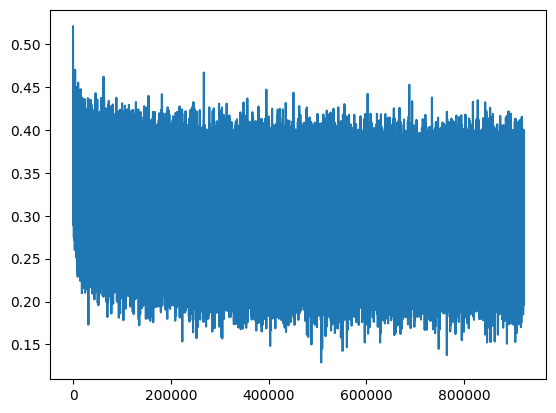

In [160]:
# plot loss
plt.plot(inxs, np.log10(losses))
# plt.xscale("log")

layer 2 (      Tanh): mean +0.00, std 0.72, saturated: 18.03%
layer 5 (      Tanh): mean +0.00, std 0.75, saturated: 20.94%
layer 8 (      Tanh): mean -0.02, std 0.79, saturated: 23.30%
layer 11 (      Tanh): mean -0.01, std 0.81, saturated: 26.91%
layer 14 (      Tanh): mean -0.01, std 0.83, saturated: 35.92%


Text(0.5, 1.0, 'activation distribution')

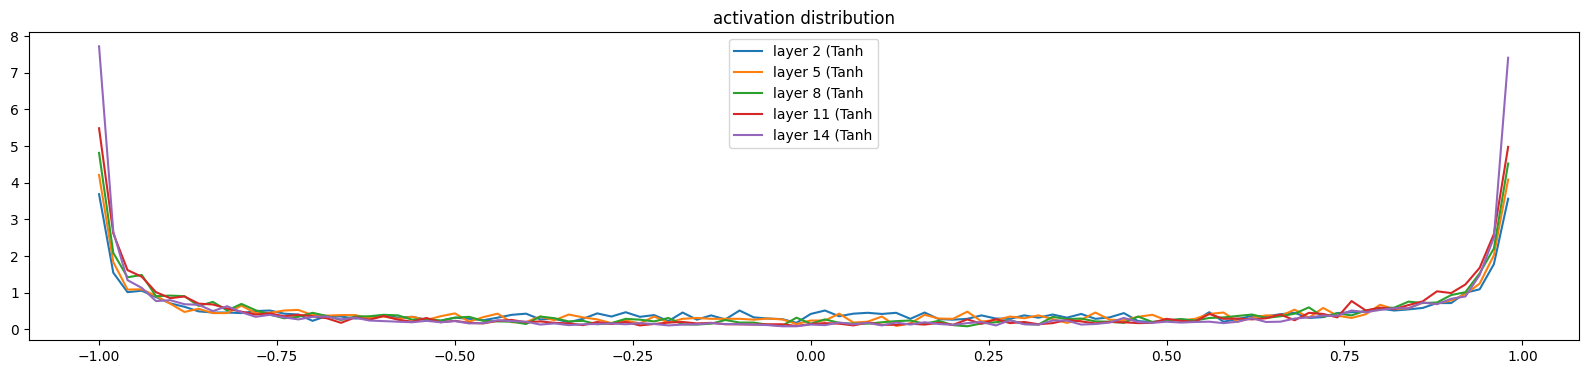

In [161]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.709341e-03
layer 5 (      Tanh): mean +0.000000, std 2.506454e-03
layer 8 (      Tanh): mean -0.000000, std 2.369330e-03
layer 11 (      Tanh): mean -0.000000, std 2.301159e-03
layer 14 (      Tanh): mean -0.000000, std 2.326739e-03


Text(0.5, 1.0, 'gradient distribution')

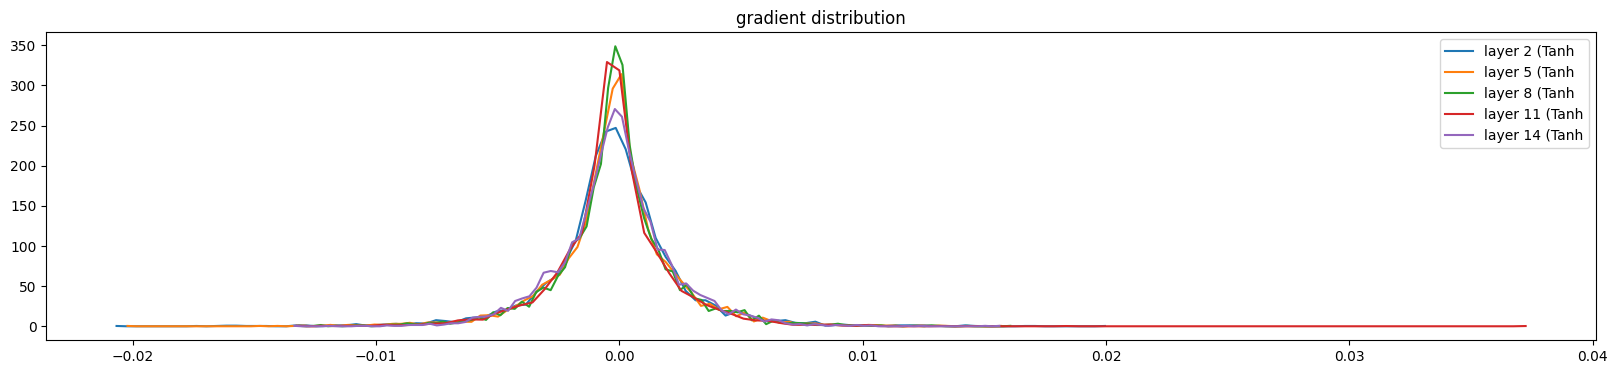

In [162]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.292007e-02 | grad:data ratio 1.087740e-02
weight  (30, 100) | mean +0.000144 | std 7.337022e-03 | grad:data ratio 1.500807e-02
weight (100, 100) | mean +0.000014 | std 5.314026e-03 | grad:data ratio 1.724351e-02
weight (100, 100) | mean -0.000028 | std 4.996123e-03 | grad:data ratio 1.660444e-02
weight (100, 100) | mean -0.000023 | std 4.844939e-03 | grad:data ratio 1.659077e-02
weight (100, 100) | mean -0.000039 | std 4.655174e-03 | grad:data ratio 1.653579e-02
weight  (100, 27) | mean -0.000077 | std 6.850384e-03 | grad:data ratio 1.648980e-02


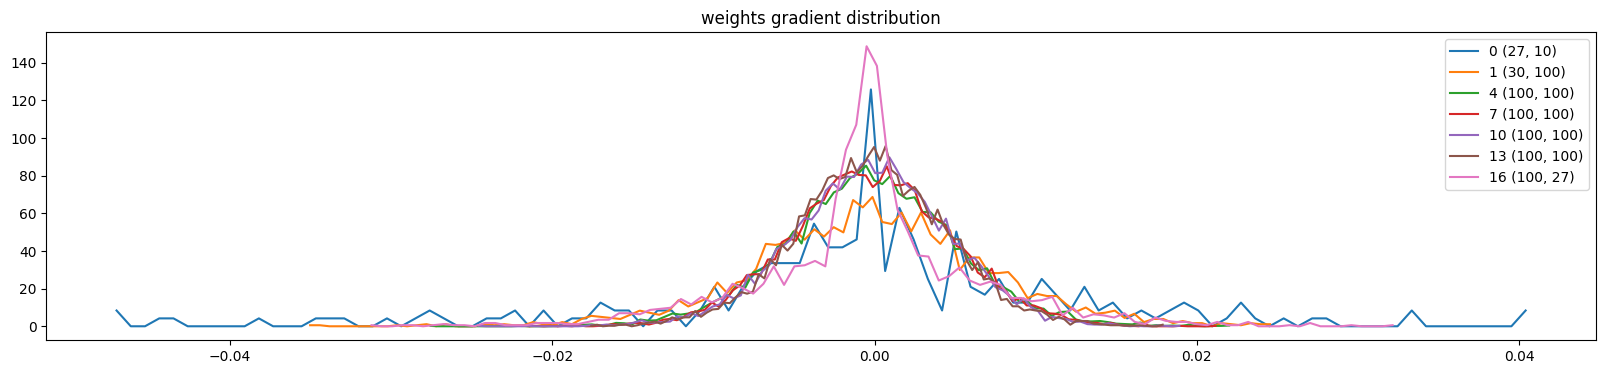

In [163]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
# plt.figure(figsize=(20, 4))
# legends = []
# for i,p in enumerate(parameters):
#   if p.ndim == 2:
#     plt.plot([ud[j][i] for j in range(len(ud))])
#     legends.append('param %d' % i)
# plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# plt.legend(legends);

NameError: name 'ud' is not defined

<Figure size 2000x400 with 0 Axes>

In [164]:
@torch.no_grad() # disable gradient tracking
def get_loss(data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    for layer in layers:
        layer.training = False

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(data_set, loss.item())

get_loss('train')
get_loss('dev')

train 1.9355193376541138
dev 2.067014694213867


In [165]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = '.' * block_size
	while True:
		emb = C[torch.tensor([str_to_inx[x] for x in out[-block_size:]])] # (1,block_size,d)
		# print(emb)
		x = emb.view(1, block_size*n_embd)
		for layer in layers:
			x = layer(x)
		probs = F.softmax(x, dim=1)
		inx = torch.multinomial(probs, num_samples=1, generator=g).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

carmah
amelle
khyrilli
tatyannah
sky
mahni
faverynce
geni
ner
kiah
maiiv
kaleigh
ham
joce
quinthorline
liveni
waterri
jarynn
jace
pius
